In [140]:
# Compute the committor for LJ7 using FEM
import numpy as np
import scipy
import matplotlib.pyplot as plt
import re # for reading data from txt files
import random
import scipy.sparse as sp
from scipy.sparse.linalg import eigsh
from mpl_toolkits.mplot3d import Axes3D
import torch

Natoms = 7 # the number of atoms
DIM = 2 # the dimension of each atom

In [2]:
# a function for reading .txt files
def read_txt_file(fname):
    # read free energy
    data = []
    with open(fname, "r") as f:
        for line in f:
            # cleaning the bad chars in line
            line = line.strip()
            line = line.strip(" \\n")
            line = re.sub(r"(-[0-9]+\.)", r" \1", line)
            values = [float(value) for value in line.split()]
            data.append(values)
        print(np.shape(data))
        data = np.array(data)
        print(np.shape(data))
    return data

In [3]:
# the function for computing the matrix of distances squared
def Dist_Sq_Matrix(x):
    # x must be 2-by-Natoms
    Na = np.size(x,axis = 1)
    D2 = np.zeros((Na,Na))
    for j in range(Na):
        D2[j,:] = (x[0,:]-x[0,j])**2 + (x[1,:]-x[1,j])**2
    return D2

# the feature map: sorted vector of coordination numbers
def sort_coord_num(x):
    Na = np.size(x,axis = 1)
    D2 = Dist_Sq_Matrix(x)
    coord_num = np.zeros((Na,))
    for j in range(Na):
        ind = np.setdiff1d(range(Na),np.array([j]))
        aux = (D2[j,ind]/2.25)**4
        coord_num[j] = np.sum((np.ones((1,Na-1))-aux)/(np.ones((1,Na-1))-aux**2))
    return np.sort(coord_num) 

# the Lennard-Jones potential energy function
def LJ_energy(xy):
    x = np.reshape(xy,(DIM,Natoms))
    D2 = Dist_Sq_Matrix(x)
    LJ = 0
    for i in range(1,Natoms):
        for j in range(i):
            LJ = LJ + D2[i,j]**(-12)-D2[i,j]**(-6)

    LJ = LJ*4
    return LJ
    

In [4]:
# read data file
# Data are generated by recording a single representative configuration in the CV grid
fname = "LJ7bins_confs.txt"
data_bins = read_txt_file(fname)
N,d = np.shape(data_bins)

# remove all zero configurations (this is an artifact of the method by which this dataset is created)
Ikeep = np.zeros((N,))
for j in range(N):
    x = data_bins[j,:]
    if np.sum(x**2) > 1e-10:
        Ikeep[j] = 1

idx = np.argwhere(Ikeep == 1).ravel()
data_aux = data_bins[idx,:]
N,d = np.shape(data_aux)
print(np.shape(data_aux))

# subsample the dataset by selecting 5000 random entries
perm = np.random.permutation(N)
N = 5000
data1 = data_aux[perm[:N],:]
print(np.shape(data1))

# work with the dataset data1

(16641, 14)
(16641, 14)
(10071, 14)
(5000, 14)


In [11]:
#Setting up parameters
eps_par_array=np.array([0.5,1,1.5,2])
k_array=2**np.array([7,8,9,10,11])

In [41]:
#Formatting data
data=np.zeros([2,7,5000])
for i in range(5000):
    data[:,:,i]=np.vstack((data1[i,:7],data1[i,7:]))

In [45]:
data.shape

(2, 7, 5000)

In [49]:
#Computing features
features=np.zeros([5000,7])
for i in range(5000):
    features[i,:]=sort_coord_num(data[:,:,i])

In [51]:
features.shape

(5000, 7)

In [126]:
#Computing potential at data points
potential=np.zeros(5000,)
for i in range(5000):
    potential[i]=LJ_energy(data[:,:,i])

In [102]:
# the construction of the generator matrix with knn
def make_generator_k(xy, eps_par,k):
    r2 = 9*eps_par  # radius squared of the neighborhood (removed semicolon)
    
    # construct the similarity matrix
    N = np.size(xy, axis=0)
    e0 = np.ones((N,))
    
    # Use lil_matrix for efficient construction with indexing
    K = scipy.sparse.lil_matrix((N, N), dtype=float)
    
    for j in range(N):
        d2 = np.sum((xy-np.outer(e0, xy[j,:]))**2, axis=1)
        # Use ravel() to convert to 1D array of indices
        indexes1 = np.argwhere(d2 - r2 < 0).ravel()
        if len(indexes1)<k+1:
            ind=indexes1
        else:
            indexed_arr = [(value, index) for index, value in enumerate(d2[indexes1])]
            indexed_arr.sort(key=lambda x: x[0])
            indexes2=np.array([index for value, index in indexed_arr[:k]])
            ind=indexes1[indexes2]
        K[j, ind] = np.exp(-d2[ind]/eps_par)
    K=(K.T+K)/2
    
    # Convert to CSR format for efficient arithmetic operations
    K = K.tocsr()
    
    # kernel density estimation
    c = 2*np.pi*eps_par
    rho = np.sum(K, axis=1).A.ravel()/(N*c)  # .A converts to ndarray
    
    # right-normalize K
    D = scipy.sparse.diags(1/rho, 0)
    K = K @ D
    
    # left-normalize K
    rho = np.sum(K, axis=1).A.ravel()  # row sums of K
    D = scipy.sparse.diags(1/rho, 0)
    P = D @ K
    
    # Eigenvalue decomposition 
    
    return P

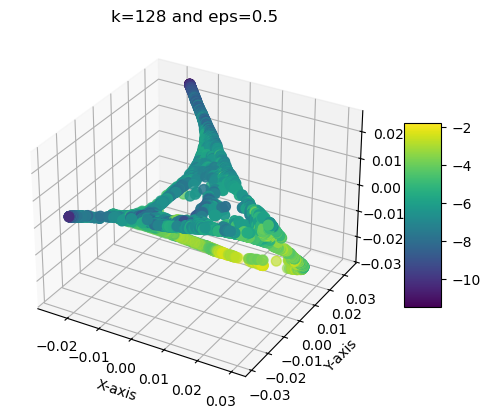

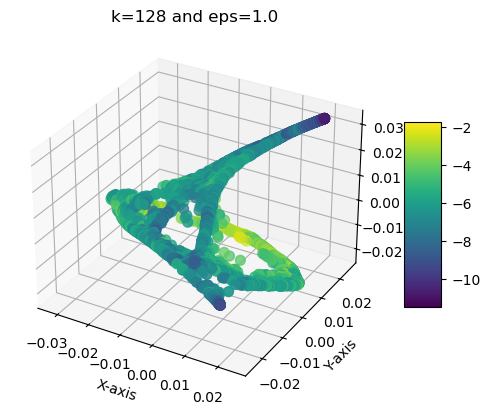

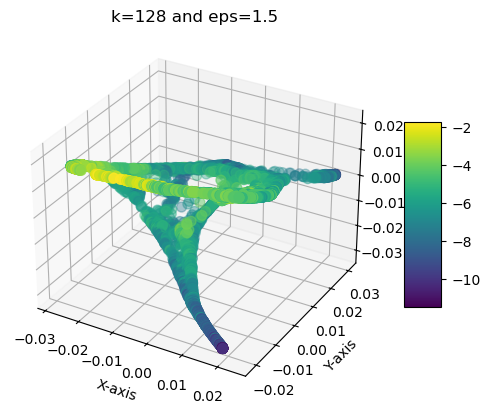

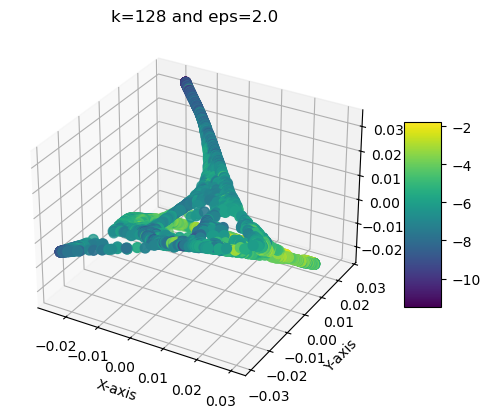

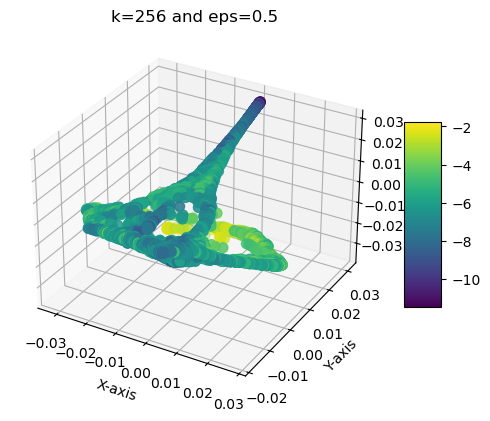

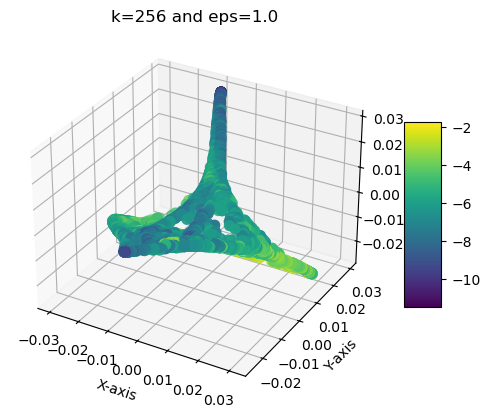

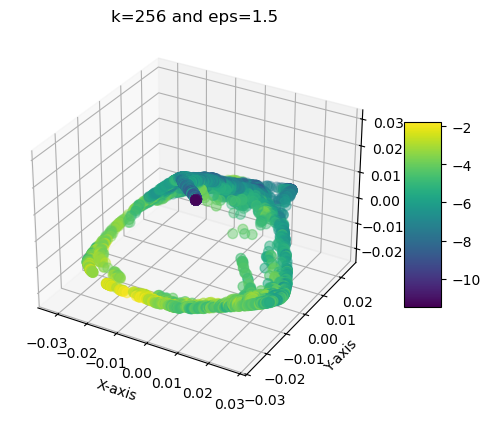

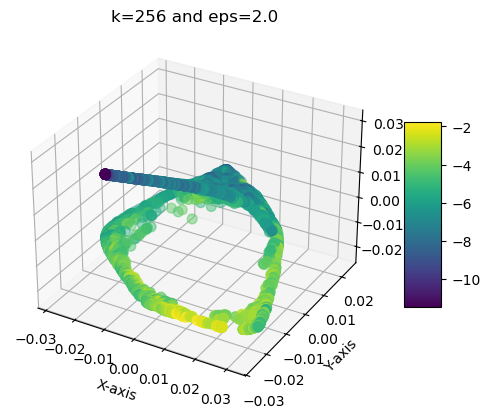

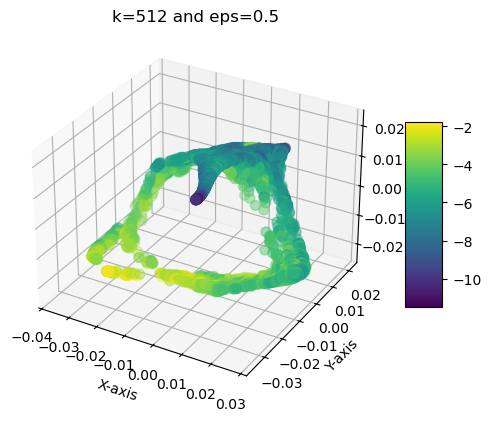

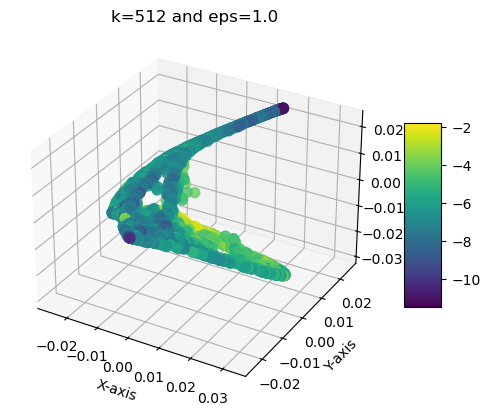

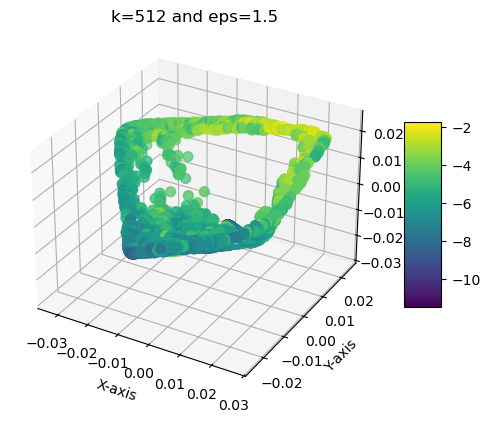

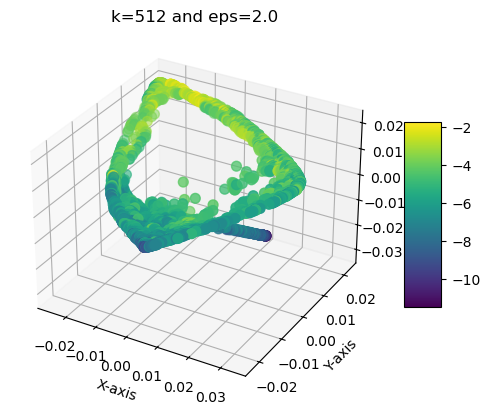

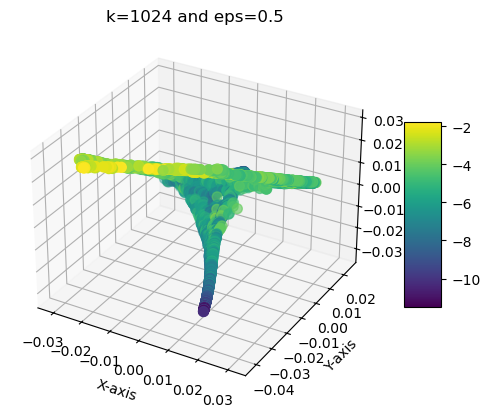

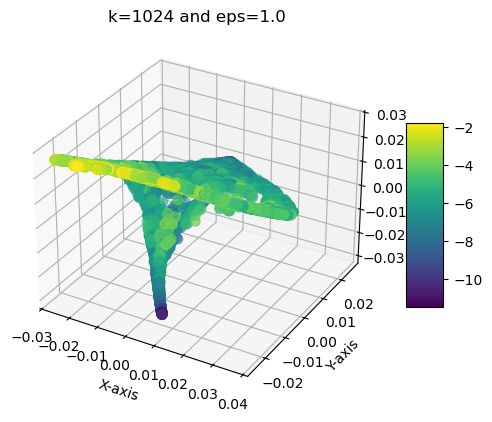

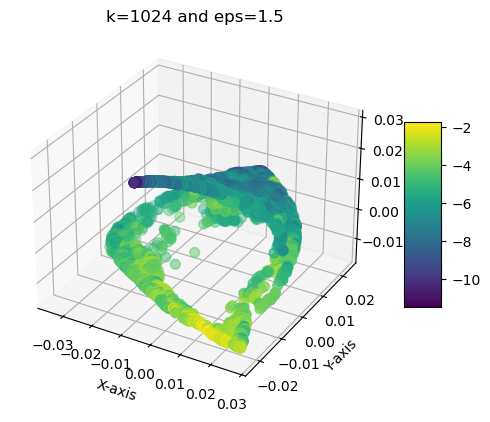

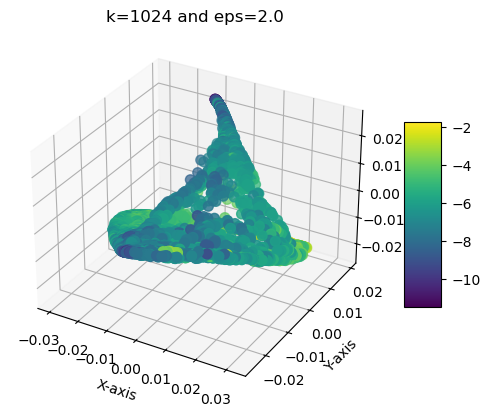

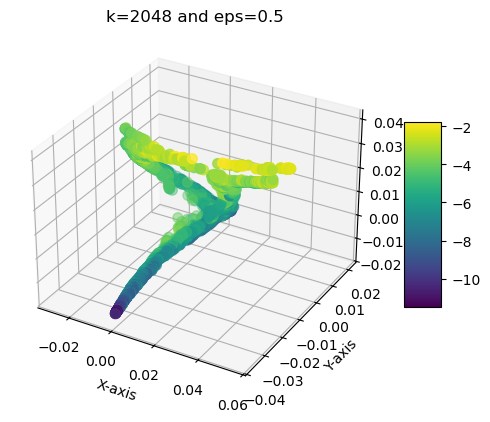

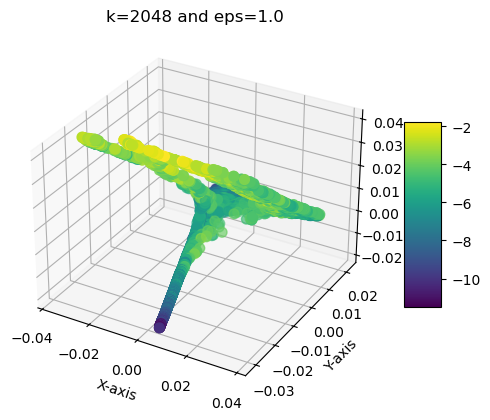

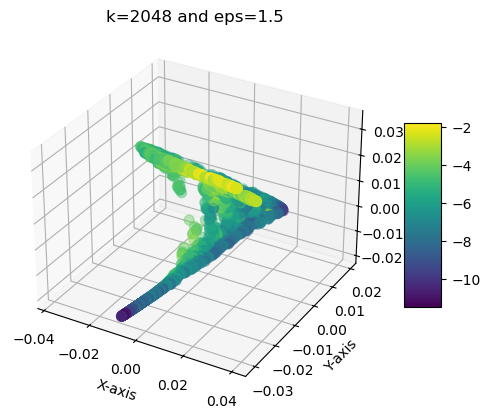

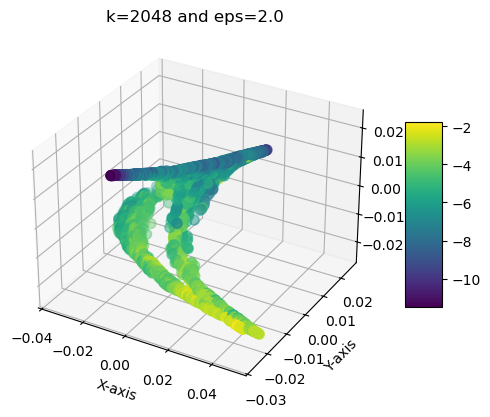

In [136]:
#Diffusion map plots for all paramters
for k in k_array:
    for eps in eps_par_array:
        P=make_generator_k(features,eps,k)
        eigenvalues, eigenvectors=eigsh(P, k=4, which='LM')
        projection=eigenvectors[:,:3]
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        scatter_plot=ax.scatter(projection[:,0], projection[:,1], projection[:,2], c=potential, cmap='viridis', s=50) 
        ax.set_xlabel('X-axis')
        ax.set_ylabel('Y-axis')
        ax.set_zlabel('Z-axis')
        ax.set_title('k='+str(k)+' and eps='+str(eps))
        fig.colorbar(scatter_plot, ax=ax, shrink=0.5, aspect=5)
        plt.show()

In [798]:
#Diffusion Net architecture
class DiffusionNet(torch.nn.Module):

    def __init__(self,in_size, hidden_size, out_size):
        super(DiffusionNet, self).__init__()

        self.linear0 = torch.nn.Linear(in_size, hidden_size)
        self.activation0 = torch.nn.ELU()
        self.linear1 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation1 = torch.nn.ELU()
        self.linear2 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation2 = torch.nn.ELU()
        self.linear3 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation3 = torch.nn.ELU()
        self.linear4 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation4 = torch.nn.ELU()
        self.linear5 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation5 = torch.nn.ELU()
        self.linear6 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation6 = torch.nn.ELU()
        self.linear7 = torch.nn.Linear(hidden_size, hidden_size)
        self.activation7 = torch.nn.ELU()
        self.linear8 = torch.nn.Linear(hidden_size, out_size)
                              
    def forward(self,x):
        q = self.linear0(x)
        q = self.activation0(q)
        q = self.linear1(q)
        q = self.activation1(q)
        q = self.linear2(q)
        q = self.activation2(q)
        q = self.linear3(q)
        q = self.activation3(q)
        q = self.linear4(q)
        q = self.activation4(q)
        q = self.linear5(q)
        q = self.activation5(q)
        q = self.linear6(q)
        q = self.activation6(q)
        q = self.linear7(q)
        q = self.activation7(q)
        q = self.linear8(q)
        return q

In [800]:
in_size = 7 # the dimension of input data points
hidden_size = 40 # the number of neurons in the hidden layer
out_size = 3 # the output size of the neural network
 
# test neural network
DNet = DiffusionNet(in_size, hidden_size, out_size)
print(DNet)

DiffusionNet(
  (linear0): Linear(in_features=7, out_features=40, bias=True)
  (activation0): ELU(alpha=1.0)
  (linear1): Linear(in_features=40, out_features=40, bias=True)
  (activation1): ELU(alpha=1.0)
  (linear2): Linear(in_features=40, out_features=40, bias=True)
  (activation2): ELU(alpha=1.0)
  (linear3): Linear(in_features=40, out_features=40, bias=True)
  (activation3): ELU(alpha=1.0)
  (linear4): Linear(in_features=40, out_features=40, bias=True)
  (activation4): ELU(alpha=1.0)
  (linear5): Linear(in_features=40, out_features=40, bias=True)
  (activation5): ELU(alpha=1.0)
  (linear6): Linear(in_features=40, out_features=40, bias=True)
  (activation6): ELU(alpha=1.0)
  (linear7): Linear(in_features=40, out_features=40, bias=True)
  (activation7): ELU(alpha=1.0)
  (linear8): Linear(in_features=40, out_features=3, bias=True)
)


In [802]:
#Choosing optimal parameters and generating training data target from diffusion map
P=make_generator_k(features,1.5,2**9)
eigenvalues, eigenvectors=eigsh(P, k=4, which='LM')
projection=eigenvectors[:,:3]
projection_torch=torch.from_numpy(projection).to(torch.float32)

In [803]:
#Standardizing training data target
y_mean = projection_torch.mean(dim=0, keepdim=True)
y_std  = projection_torch.std(dim=0, keepdim=True)

projection_norm = (projection_torch - y_mean) / y_std

In [804]:
#Getting training data ready for training in batches
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.optim as optim

train_data=torch.from_numpy(features).float()
size1,size2 = train_data.shape

rhs = projection_norm

train_dataset = TensorDataset(train_data,rhs)

batch_size = 256 # the batch size is the size of the training data/125

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

loss_fn = torch.nn.MSELoss()

# Here we define the optimizer with learning rate 5e-2:
optimizer1 = optim.Adam(DNet.parameters(), lr=1e-3)

# reduce the learning rate at the listed epochs by the factor of gamma
scheduler1 = optim.lr_scheduler.MultiStepLR(optimizer1, milestones=[500,700,900], gamma=0.1)

In [808]:
#Training
Nepochs = 1000
loss = 1
for epoch in range(Nepochs):
    epoch_loss = 0
    for X, y in train_dataloader:
        optimizer1.zero_grad()
        q = DNet(X)
        loss = loss_fn(q, y)
        loss.backward()
        optimizer1.step()
        epoch_loss += loss.item() * X.size(0)

    scheduler1.step()
    epoch_loss /= len(train_dataset)

    if epoch % 10 == 0:
        print(f"epoch {epoch} loss = {epoch_loss:.6f}")


epoch 0 loss = 0.990825
epoch 10 loss = 0.024016
epoch 20 loss = 0.011870
epoch 30 loss = 0.008849
epoch 40 loss = 0.007516
epoch 50 loss = 0.006643
epoch 60 loss = 0.006132
epoch 70 loss = 0.005216
epoch 80 loss = 0.004564
epoch 90 loss = 0.004659
epoch 100 loss = 0.003648
epoch 110 loss = 0.002664
epoch 120 loss = 0.002664
epoch 130 loss = 0.001716
epoch 140 loss = 0.001657
epoch 150 loss = 0.001618
epoch 160 loss = 0.001405
epoch 170 loss = 0.001675
epoch 180 loss = 0.001411
epoch 190 loss = 0.001174
epoch 200 loss = 0.001136
epoch 210 loss = 0.001126
epoch 220 loss = 0.001177
epoch 230 loss = 0.001025
epoch 240 loss = 0.001249
epoch 250 loss = 0.001090
epoch 260 loss = 0.000904
epoch 270 loss = 0.001222
epoch 280 loss = 0.000943
epoch 290 loss = 0.000916
epoch 300 loss = 0.000851
epoch 310 loss = 0.000923
epoch 320 loss = 0.000981
epoch 330 loss = 0.000863
epoch 340 loss = 0.000970
epoch 350 loss = 0.000793
epoch 360 loss = 0.000900
epoch 370 loss = 0.001599
epoch 380 loss = 0.0007

In [809]:
#Testing data OOD from LJ7
data_out=np.zeros([2,7,10071])
for i in range(10071):
    data_out[:,:,i]=np.vstack((data_aux[i,:7],data_aux[i,7:]))
features_out=np.zeros([10071,7])
for i in range(10071):
    features_out[i,:]=sort_coord_num(data_out[:,:,i])

In [810]:
potential_out=np.zeros(10071,)
for i in range(10071):
    potential_out[i]=LJ_energy(data_out[:,:,i])

In [811]:
DNetproj=DNet(torch.from_numpy(features_out).to(torch.float32))*y_std + y_mean

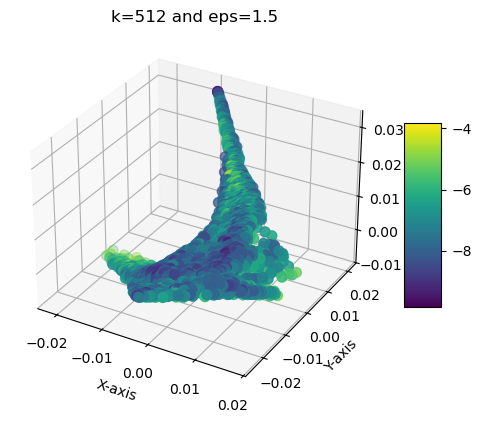

In [812]:
#Output
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
proj_numpy=DNetproj.detach().numpy()
scatter_plot=ax.scatter(proj_numpy[:,0], proj_numpy[:,1], proj_numpy[:,2], c=potential_out, cmap='viridis', s=50) 
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('k=512 and eps=1.5')
fig.colorbar(scatter_plot, ax=ax, shrink=0.5, aspect=5)
plt.show()

In [813]:
# read data file
# Data are generated by recording a single representative configuration in the CV grid
fname = "MALAtrajectory.txt"
data_bins = read_txt_file(fname)
N,d = np.shape(data_bins)

# remove all zero configurations (this is an artifact of the method by which this dataset is created)
Ikeep = np.zeros((N,))
for j in range(N):
    x = data_bins[j,:]
    if np.sum(x**2) > 1e-10:
        Ikeep[j] = 1

idx = np.argwhere(Ikeep == 1).ravel()
data_aux = data_bins[idx,:]
N,d = np.shape(data_aux)
print(np.shape(data_aux))

(100001, 14)
(100001, 14)
(100001, 14)


In [814]:
#Test data from MALA
data_out=np.zeros([2,7,100001])
for i in range(100001):
    data_out[:,:,i]=np.vstack((data_aux[i,:7],data_aux[i,7:]))
features_out=np.zeros([100001,7])
for i in range(100001):
    features_out[i,:]=sort_coord_num(data_out[:,:,i])
potential_out=np.zeros(100001,)
for i in range(100001):
    potential_out[i]=LJ_energy(data_out[:,:,i])

In [815]:
DNetproj=DNet(torch.from_numpy(features_out).to(torch.float32))*y_std + y_mean

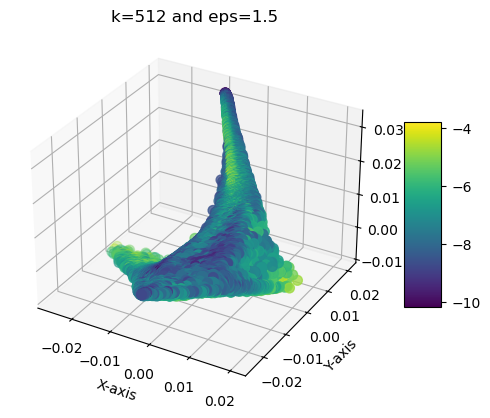

In [816]:
#Results
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
proj_numpy=DNetproj.detach().numpy()
scatter_plot=ax.scatter(proj_numpy[:,0], proj_numpy[:,1], proj_numpy[:,2], c=potential_out, cmap='viridis', s=50) 
ax.set_xlabel('X-axis')
ax.set_ylabel('Y-axis')
ax.set_zlabel('Z-axis')
ax.set_title('k=512 and eps=1.5')
fig.colorbar(scatter_plot, ax=ax, shrink=0.5, aspect=5)
plt.show()